### IE801 물류관리 HW1

- 이름 : 이강훈
- 학번 : 20203421

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time

### Generating Graph

생성되는 그래프는 다음의 조건들을 만족한다.

- source node는 1번 노드이다.
- 각 노드의 incoming edge는 자기 자신보다 낮은 index의 노드로만 형성된다.
- 각 노드의 outgoing edge는 자기 자신보다 높은 index의 노드로만 형성된다.
- source node를 제외한 모든 노드는 최소 1개의 incoming edge를 가진다.
- 각 노드의 incoming edge, outgoing edge의 합은 최소 'degree' 이다.

위의 조건을 통해 다음의 특징을 가진다.

- source node에서 모든 노드까지의 path가 존재한다.
- 그래프에는 cycle이 존재하지 않는다.

하지만, 이렇게 생성된 graph는 인덱스가 작은 노드부터 차례대로 경로를 탐색하면, <br>
기존의 bellman-ford 알고리즘으로 빠르게 해결되는 특성을 가지게 된다. <br>
그러므로, source node를 제외하고 node들을 relable 한다.

In [2]:
def cost_function(negative_prob=0.0):
    
    if random.random() < negative_prob:
        return -random.random()
    else:
        return random.random()

In [3]:
def remapper(num_nodes):
    remap = {1:1}
    target_node = list(range(2, num_nodes+1))
    random.shuffle(target_node)
    for i in range(2, num_nodes+1):
        remap[i] = target_node[i-2]
    return remap

In [4]:
def generate_network(num_nodes, degree, min_edge, cost_function, negative_prob):
    
    while True:
        G = nx.DiGraph()
        G.add_node(num_nodes)

        for i in range(1, num_nodes+1):
            pool = list(range(1, num_nodes+1))
            pool.remove(i)
            picked_nodes = random.sample(pool, degree)

            in_num = 0
            for picked_node in picked_nodes:
                if i < picked_node:
                    G.add_edge(i, picked_node, cost=cost_function())
                else:
                    G.add_edge(picked_node, i, cost=cost_function())
                    in_num += 1

            if i > 1 and in_num <= 0:
                picked_node = random.sample(list(range(1, i)), 1)[0]
                G.add_edge(picked_node, i, cost=cost_function())
        
        if G.number_of_edges() > min_edge:
            
            pool = list(range(1, G.number_of_edges()))
            num_negative = round(G.number_of_edges() * negative_prob)
            negative_edges = random.sample(pool, num_negative)
            
            for i in negative_edges:
                u, v = list(G.edges())[i]
                G[u][v]['cost'] = -G[u][v]['cost']
                
            mapping = remapper(num_nodes)
            G = nx.relabel_nodes(G, mapping)
            
            return G

### Test 'generate_network' function

- 네트워크가 어떻게 생성되었는지 visualize
- source node(1번 노드)는 다른색으로 구분

In [5]:
def make_colormap(num_nodes, source_color='coral', basic_color='lightgreen'):
    color = []
    for i in pos.keys():
        if i == 1:
            color.append(source_color)
        else:
            color.append(basic_color)
    return color

number of nodes :  20
number of edges :  44


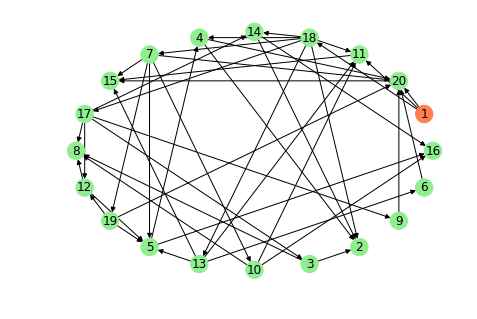

In [7]:
num_nodes = 20
degree = 2
min_edge = 40

G = generate_network(num_nodes=num_nodes, 
                     degree=degree, 
                     min_edge=min_edge, 
                     cost_function=cost_function, 
                     negative_prob=0.1)

print("number of nodes : ", G.number_of_nodes())
print("number of edges : ", G.number_of_edges())

pos = nx.circular_layout(G)
color = make_colormap(num_nodes)
nx.draw(G, pos, node_color = color, with_labels = True)


### Bellman-Ford Algorithm

- source node 에서 각 node 별로 최단 경로, 최소 비용을 구하는 알고리즘
- $d[i]$ : cost to $i$
- $prev[i]$ : previous node for path-$i$

In [8]:
def bellman_ford(G):
    
    # define variable
    d = ['dummy'] + [0] + [1e+6] * (G.number_of_nodes() - 1)
    prev = ['dummy'] + [-1] * G.number_of_nodes()
    
    cnt = 0
    for _ in range(1, len(d)):        
        for i, j in G.edges():
            cnt += 1
            if d[j] > d[i] + G[i][j]['cost']:
                d[j] = d[i] + G[i][j]['cost']
                prev[j] = i
    
    return d[1:], prev[1:], cnt

### Test Bellman-Ford Algorithm

- bellman-ford 알고리즘 테스트

In [14]:
def path_beautiful(d, prev):
    
    path = ['1'] + [''] * (len(d) - 1)
    
    for i in range(20):
        cur_id = i
        path_i = str(i+1)
        while prev[cur_id] != -1:
            path_i = str(prev[cur_id]) + ' -> ' + path_i
            cur_id = prev[cur_id] - 1
        
        print("node {:2d} / cost : {:1.4f} / path : {}"
              .format(i+1, d[i], path_i))
        
    return path

In [15]:
d, prev, _ = bellman_ford(G)
path = path_beautiful(d, prev)

node  1 / cost : 0.0000 / path : 1
node  2 / cost : -0.5139 / path : 1 -> 18 -> 2
node  3 / cost : 1.1018 / path : 1 -> 18 -> 17 -> 3
node  4 / cost : 0.8711 / path : 1 -> 18 -> 4
node  5 / cost : 1.0206 / path : 1 -> 18 -> 17 -> 12 -> 5
node  6 / cost : 2.0844 / path : 1 -> 18 -> 13 -> 6
node  7 / cost : 0.9919 / path : 1 -> 18 -> 7
node  8 / cost : 1.5190 / path : 1 -> 18 -> 17 -> 8
node  9 / cost : 1.8252 / path : 1 -> 18 -> 17 -> 9
node 10 / cost : 1.5796 / path : 1 -> 18 -> 7 -> 10
node 11 / cost : 0.5023 / path : 1 -> 11
node 12 / cost : 0.9782 / path : 1 -> 18 -> 17 -> 12
node 13 / cost : 1.4338 / path : 1 -> 18 -> 13
node 14 / cost : 0.4895 / path : 1 -> 18 -> 14
node 15 / cost : 0.7704 / path : 1 -> 11 -> 15
node 16 / cost : 0.5613 / path : 1 -> 18 -> 14 -> 16
node 17 / cost : 0.8655 / path : 1 -> 18 -> 17
node 18 / cost : 0.4682 / path : 1 -> 18
node 19 / cost : 1.1118 / path : 1 -> 18 -> 7 -> 19
node 20 / cost : 0.7824 / path : 1 -> 20


### Modified Bellman-Ford Algorithm - add & remove

- check list 에서 어떤 item 을 remove 해야할까?
- check list 에서 item 을 어떤 위치에 add 해야할까?

여러가지 방식이 있을 수 있는데, 다음과 같은 방법을 생각할 수 있다.

1. FIFO
    - remove : 맨 앞에 있는 item
    - add : 맨 뒤에 add


2. Dequeue
    - remove : 맨 앞에 있는 item
    - add : 새로운 node의 경우 맨 뒤에, 다시 들어온 node의 경우 맨 앞에


3. Random
    - remove : random 한 위치에 있는 item
    - add : random 한 위치에 add

In [16]:
class FIFO_method:
    
    def __init__(self):
        pass
    
    def remove(self, check_list):
        return check_list.pop(0)
    
    def add(self, check_list, idx):
        check_list.append(idx)

In [17]:
class Dequeue_method:
    
    def __init__(self):
        self.visited = []
    
    def remove(self, check_list):
        return check_list.pop(0)
    
    def add(self, check_list, idx):
        if idx in self.visited:
            check_list.insert(0, idx)
        else:
            self.visited.append(idx)
            check_list.append(idx)

In [18]:
class Random_method:
    
    def __init__(self):
        pass
    
    def remove(self, check_list):
        return check_list.pop(random.randrange(len(check_list)))
    
    def add(self, check_list, idx):
        check_list.insert(random.randrange(len(check_list)+1), idx)

### Modified Bellman-Ford Algorithm

여러가지 add, remove method를 사용할 수 있는 bellman-ford 함수 정의.

In [19]:
def make_edge_dict(G):

    edge_dict = {}
    
    for u, v in G.edges():
        if not (u in edge_dict.keys()):
            edge_dict[u] = [v]
        else:
            edge_dict[u] += [v]

    return edge_dict

In [20]:
def modified_bellman_ford(G, method):
    
    # define variable
    d = ['dummy'] + [0] + [1e+6] * (G.number_of_nodes() - 1)
    prev = ['dummy'] + [-1] * G.number_of_nodes()
    check_list = [1]
    
    edge_dict = make_edge_dict(G)
    cnt = 0
    while len(check_list) != 0:
        i = method.remove(check_list)
        if not (i in edge_dict.keys()):
            continue
            
        for j in edge_dict[i]:
            cnt += 1
            if d[j] > d[i] + G[i][j]['cost']:
                d[j] = d[i] + G[i][j]['cost']
                prev[j] = i
                if not (j in check_list):
                    method.add(check_list, j)
    
    return d[1:], prev[1:], cnt

### Problem 1 : Compare the performances of the methods

- graph generation : 5000 graphs for test
- (Todo) graph generation : (50 test sets) * (100 graphs) for test

In [21]:
def make_test_sets(negative_prob):

    num_nodes = 20
    degree = 2
    min_edge = 40

    test_sets = 100
    graph_set_num = 100

    Graphs = []
    for _ in range(test_sets):
        Graphs_temp = []
        for _ in range(graph_set_num):
            G = generate_network(num_nodes=num_nodes, 
                                 degree=degree, 
                                 min_edge=min_edge, 
                                 cost_function=cost_function, 
                                 negative_prob=negative_prob)
            Graphs_temp.append(G)
        Graphs.append(Graphs_temp)
    return Graphs

In [23]:
test_sets = make_test_sets(negative_prob=0.1)

In [25]:
cnts = []
for Gs in test_sets:
    cnt = 0
    for G in Gs:
        _, _, cnt_ = modified_bellman_ford(G, method=FIFO_method())
        cnt += cnt_
    cnts.append(cnt/100)
print("FIFO : ", sum(cnts)/len(cnts))

FIFO :  47.508799999999994


In [26]:
cnts = []
for Gs in test_sets:
    cnt = 0
    for G in Gs:
        _, _, cnt_ = modified_bellman_ford(G, method=Dequeue_method())
        cnt += cnt_
    cnts.append(cnt/100)
print("Dequeue : ", sum(cnts)/len(cnts))

Dequeue :  46.65189999999998


In [27]:
cnts = []
for Gs in test_sets:
    cnt = 0
    for G in Gs:
        _, _, cnt_ = modified_bellman_ford(G, method=Random_method())
        cnt += cnt_
    cnts.append(cnt/100)
print("Random : ", sum(cnts)/len(cnts))

Random :  48.8943
